*   This is to support part V.B.ii in our paper
*   We factor sentiment element into Tweets and then visualize the relationship between Amazon stock price and Tweets

In [ ]:
%matplotlib inline 

import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

In [ ]:
#Use dataframe that we exported from coding file "V_A_Tweet_Sentiment_Analysis" and stock price data from Kaggle
Google = pd.read_csv('Google.csv')
company_value = pd.read_csv('CompanyValues.csv')
company_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [ ]:
#company_value['ticker_symbol'] = company_value['ticker_symbol'].apply(lambda company: 'GOOGL' if company == 'GOOG')
company_value.loc[company_value['ticker_symbol']== 'GOOG', 'ticker_symbol'] = 'GOOGL'

In [ ]:
#Add column of daily returns into the stock price table
company_value['returns'] = company_value.sort_values('day_date').groupby(['ticker_symbol']).close_value.pct_change()
Google_value = company_value[company_value['ticker_symbol'] == 'GOOGL'].sort_values('day_date')
Google_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns
8686,GOOGL,2010-06-01,243.6667,2664303,242.6868,248.0565,242.5302,NaN
8685,GOOGL,2010-06-02,249.2233,2513109,245.8439,249.4759,243.2071,0.022804
8684,GOOGL,2010-06-03,255.4013,3646724,250.1023,256.6136,249.8952,0.024789
8683,GOOGL,2010-06-04,251.9259,3909809,252.4310,257.2450,250.9055,-0.013608
8682,GOOGL,2010-06-07,245.2580,3628970,252.0976,253.0321,244.0608,-0.026468


In [ ]:
#Merge Tweets content and stock price dataframe
Google_tweet_vs_value =  pd.merge(Google, Google_value, left_on=['post_date'], right_on = ['day_date'], how= "inner")
Google_tweet_vs_value['post_date'] = Google_tweet_vs_value['post_date'].apply(lambda date: pd.to_datetime(date))
Google_tweet_vs_value.head()

,Unnamed: 0,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,sentiment_scores,score,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns
0,3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,GOOGL,2015-01-01,530.66,1235889,537.74,538.4,530.2,0.008093
1,3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,GOOGL,2015-01-01,526.40,1367110,531.25,532.6,525.8,-0.008028
2,17,550795088821886976,GOOGL,MarkDePompeo,2015-01-01,"""@CNBC: This is Wall Street's top pick in 2015...",0,0,0,0,"{'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...",Positive,GOOGL,2015-01-01,530.66,1235889,537.74,538.4,530.2,0.008093
3,17,550795088821886976,GOOGL,MarkDePompeo,2015-01-01,"""@CNBC: This is Wall Street's top pick in 2015...",0,0,0,0,"{'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...",Positive,GOOGL,2015-01-01,526.40,1367110,531.25,532.6,525.8,-0.008028
4,44,550780769497808896,GOOG,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,3,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",Positive,GOOGL,2015-01-01,530.66,1235889,537.74,538.4,530.2,0.008093


In [ ]:
#Allocate the numeric score into n_score attribute for each sentiment status: Positive = 1; Neutral = 0.5; Negative = -1
n_score = []
for i in range(len(Google_tweet_vs_value['score'])):
    if Google_tweet_vs_value['score'][i] == 'Positive':
        n_score.append(1)
    elif Google_tweet_vs_value['score'][i] == 'Neutral':
        n_score.append(0.5)
    elif Google_tweet_vs_value['score'][i] == 'Negative':
        n_score.append(-1)
Google_tweet_vs_value['n_score'] = n_score
Google_tweet_vs_value.head(100)

#Calculate the total score of each Tweet
total_score = []
for i in range(len(Google_tweet_vs_value['total_engangement'])):
    total_score.append(Google_tweet_vs_value['total_engangement'][i]*Google_tweet_vs_value['n_score'][i])

Google_tweet_vs_value['total_score'] = total_score
Google_tweet_vs_value.head()

,Unnamed: 0,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,...,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns,n_score,total_score
0,3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,1,...,GOOGL,2015-01-01,530.66,1235889,537.74,538.4,530.2,0.008093,0.5,0.5
1,3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,1,...,GOOGL,2015-01-01,526.40,1367110,531.25,532.6,525.8,-0.008028,0.5,0.5
2,17,550795088821886976,GOOGL,MarkDePompeo,2015-01-01,"""@CNBC: This is Wall Street's top pick in 2015...",0,0,0,0,...,GOOGL,2015-01-01,530.66,1235889,537.74,538.4,530.2,0.008093,1.0,0.0
3,17,550795088821886976,GOOGL,MarkDePompeo,2015-01-01,"""@CNBC: This is Wall Street's top pick in 2015...",0,0,0,0,...,GOOGL,2015-01-01,526.40,1367110,531.25,532.6,525.8,-0.008028,1.0,0.0
4,44,550780769497808896,GOOG,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,3,...,GOOGL,2015-01-01,530.66,1235889,537.74,538.4,530.2,0.008093,1.0,3.0


In [ ]:
#Extract data that we want to visualize
Google_visual = Google_tweet_vs_value[['post_date','score','total_score','returns', 'close_value']]
Google_visual.head()

,post_date,score,total_score,returns,close_value
0,2015-01-01,Neutral,0.5,0.008093,530.66
1,2015-01-01,Neutral,0.5,-0.008028,526.40
2,2015-01-01,Positive,0.0,0.008093,530.66
3,2015-01-01,Positive,0.0,-0.008028,526.40
4,2015-01-01,Positive,3.0,0.008093,530.66


In [ ]:
#Group the data by post_date
Google_visual_group = Google_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()
Google_visual_group

<ipython-input-8-b704adb0e388>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Google_visual_group = Google_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()


,close_value,returns,total_score
post_date,,,
2015-01-01,528.530,0.000032,0.809524
2015-01-02,527.180,-0.000996,0.535156
2015-01-03,527.180,-0.004475,0.432886
2015-01-04,527.180,0.004516,2.000000
2015-01-05,516.665,-0.009366,0.684906
...,...,...,...
2019-12-27,1353.265,-0.003888,3.078740
2019-12-28,1353.265,0.001017,8.379808
2019-12-29,1353.265,-0.001015,2.232143


In [ ]:
Google_posneg = Google_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')
Google_posneg

<ipython-input-9-0284399908ca>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Google_posneg = Google_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')


,close_value,returns,total_score
post_date,,,
2015-01-01,528.530,0.000032,0.809524
2015-01-02,527.180,-0.000996,0.535156
2015-01-03,527.180,-0.004475,0.432886
2015-01-04,527.180,0.004516,2.000000
2015-01-05,516.665,-0.009366,0.684906
...,...,...,...
2019-12-27,1353.265,-0.003888,3.078740
2019-12-28,1353.265,0.001017,8.379808
2019-12-29,1353.265,-0.001015,2.232143


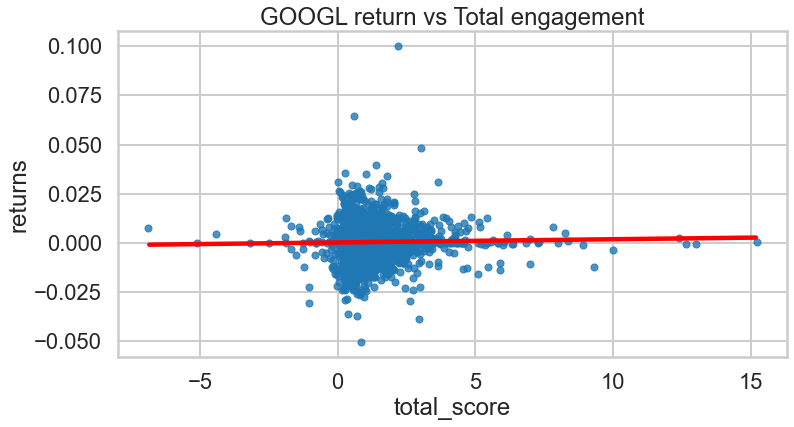

In [ ]:
#Visualize relationship between stock return and total score
sns.regplot(x='total_score', y="returns", data=Google_visual_group, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("GOOGL return vs Total engagement")
plt.show()

In [ ]:
#Filter data for positive tweets only
Google_pos = Google_visual[Google_visual['score'] == 'Positive']
Google_pos.head()

,post_date,score,total_score,returns,close_value
2,2015-01-01,Positive,0.0,0.008093,530.66
3,2015-01-01,Positive,0.0,-0.008028,526.40
4,2015-01-01,Positive,3.0,0.008093,530.66
5,2015-01-01,Positive,3.0,-0.008028,526.40
6,2015-01-01,Positive,2.0,0.008093,530.66


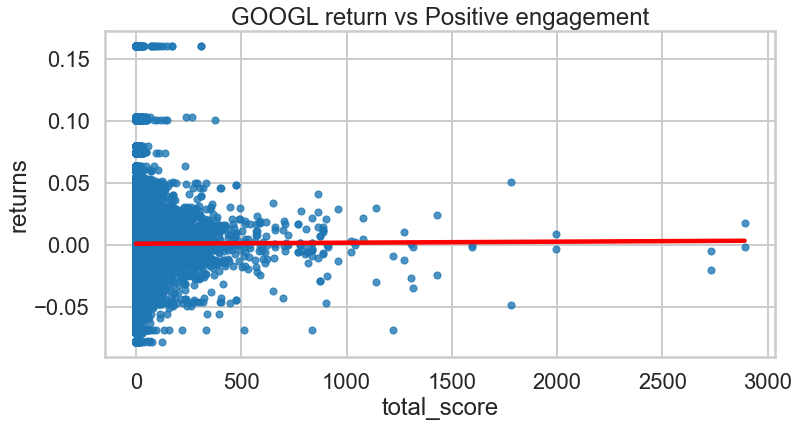

In [ ]:
#Visualize relationship between stock return and total score for positive tweets only
sns.regplot(x='total_score', y="returns", data=Google_pos, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("GOOGL return vs Positive engagement")
plt.show()

In [ ]:
#Filter data for negative tweets only
Google_neg = Google_visual[Google_visual['score'] == 'Negative']
Google_neg.head()

,post_date,score,total_score,returns,close_value
70,2015-01-01,Negative,-0.0,0.008093,530.66
71,2015-01-01,Negative,-0.0,-0.008028,526.40
78,2015-01-01,Negative,-0.0,0.008093,530.66
79,2015-01-01,Negative,-0.0,-0.008028,526.40
88,2015-01-01,Negative,-0.0,0.008093,530.66


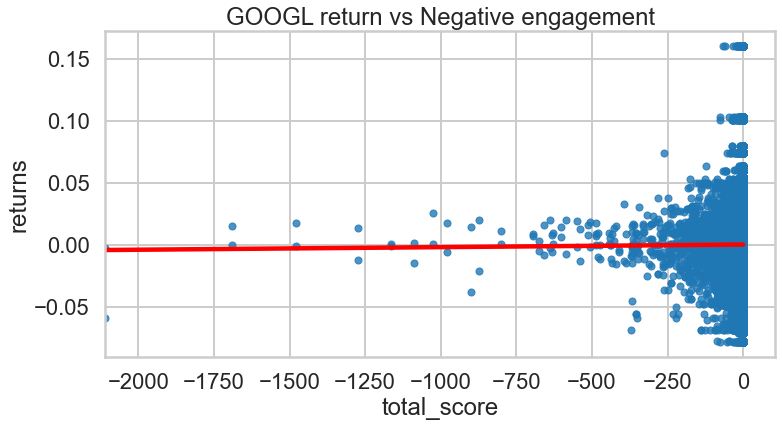

In [ ]:
#Visualize relationship between stock return and total score for negative tweets only
sns.regplot(x='total_score', y="returns", data=Google_neg, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("GOOGL return vs Negative engagement")
plt.show()

In [ ]:
Total_pos_tweets = Google_pos.groupby('post_date').mean('total_score')
Total_pos_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,1.313725,0.000032,528.530
2015-01-02,0.849558,-0.000996,527.180
2015-01-03,0.383966,-0.004475,527.180
2015-01-04,0.786885,0.004516,527.180
2015-01-05,0.971246,-0.009366,516.665


In [ ]:
Total_neg_tweets = Google_neg.groupby('post_date').mean('total_score')
Total_neg_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,0.000000,0.000032,528.530
2015-01-02,-0.741935,-0.000996,527.180
2015-01-03,-0.200000,-0.004475,527.180
2015-01-04,-0.842105,0.004516,527.180
2015-01-05,-1.215686,-0.009366,516.665


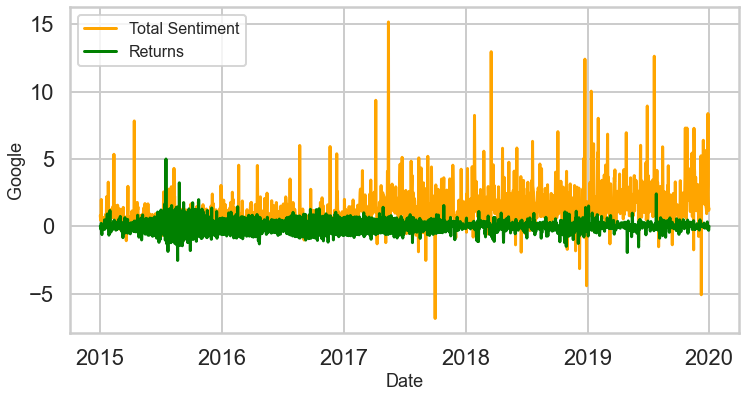

In [ ]:
#Visualize stock return and total score of sentiment per day.
Google_returns = Google_visual_group[Google_visual_group['returns'] != 0]
Google_returns['returns'] = Google_returns['returns'].apply(lambda returns: returns*50)
plt.xlabel("Date" , fontsize = 18)
plt.ylabel("Google", fontsize = 18)
sns.lineplot(
data = Google_posneg,
        x = 'post_date',
        y = 'total_score', 
        color = 'orange'
    )
sns.lineplot(
data = Google_returns,
        x = 'post_date',
        y = 'returns', 
        color = 'green'
    )
#"Positive Sentiment", "Negative Sentiment",
plt.legend(labels=["Total Sentiment", "Returns"],fontsize = 16)